In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = [20,10]

In [3]:
from NetEmbs.DataProcessing.normalize import normalize
from NetEmbs.DataProcessing.connect_db import *
from NetEmbs.GenerateData.complex_df import sales_collections
d=normalize(upload_data(limit=10))

In [4]:
from NetEmbs.FSN.graph import FSN

In [22]:
d = upload_data(limit=20)

In [23]:
d.head(100)

,ID,Name,FA_Name,Value,Debit,Credit
0,1,Revenue_5,Revenue,-61.0,0.0,61.0
1,1,Tax_5,Tax,-12.2,0.0,12.2
2,1,TradeReceivables_5,TradeReceivables,73.2,73.2,0.0
3,2,TradeReceivables_5,TradeReceivables,-73.2,0.0,73.2
4,2,Cash4,Cash,73.2,73.2,0.0
5,3,CostOfSales_9,CostOfSales,61.0,61.0,0.0
6,3,inventory9,Inventory,-61.0,0.0,61.0
7,4,Revenue_3,Revenue,-199.0,0.0,199.0
8,4,Tax_3,Tax,-39.8,0.0,39.8
9,4,TradeReceivables_3,TradeReceivables,238.8,238.8,0.0


In [24]:
fsn = FSN()
fsn.build(normalize(d), name_column="FA_Name")
fsn.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 'Revenue', 'Tax', 'TradeReceivables', 'Cash', 'CostOfSales', 'Inventory'))

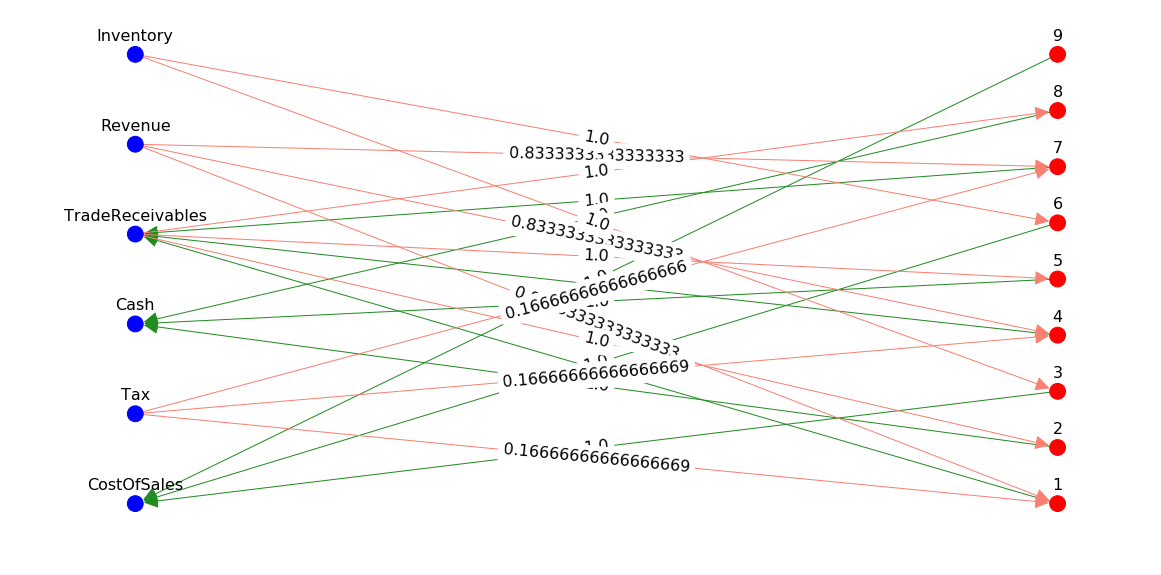

In [25]:
from NetEmbs.Vis.plots import plotFSN
plotFSN(fsn, edge_labels=True)

## Different sampling strategies

In [ ]:
from scipy.special import softmax
def def_step(G, vertex, direction="IN", weighted=False, debug=False, **kwargs):
#     One step according to the original implementation of RandomWalk by Perozzi et al.
    if vertex==-1:
#         Step cannot be made, return -1
        return -1
    elif not G.has_node(vertex):
        raise ValueError("Vertex {!r} is not in FSN!".format(vertex))
    if direction=="IN":
        ins = G.in_edges(vertex, data=True)
    elif direction=="OUT":
        ins = G.out_edges(vertex, data=True)
    else:
        raise ValueError("Wrong direction argument! {!s} used while IN or OUT are allowed!".format(direction))
    indexes = ["IN", "OUT"]
    if len(ins) > 0:
        if weighted:
            ws = list()
            tmp_vertex = None
            tmp_weight = None
            ws = [edge[-1]["weight"] for edge in ins]
            p_ws = ws / np.sum(ws)
            ins = [edge[indexes.index(direction)] for edge in ins]
            tmp_idx = np.random.choice(range(len(ins)), p=p_ws)
            tmp_vertex = ins[tmp_idx]
            tmp_weight = ws[tmp_idx]
        else:
            ins = [edge[indexes.index(direction)] for edge in ins]
            tmp_vertex = np.random.choice(ins)
        if debug:
            print(tmp_vertex)
        return tmp_vertex
    else:
        return -1

In [ ]:
cur=1
for _ in range(10):
    cur = def_step(fsn, cur)
    print(cur)

In [ ]:
from NetEmbs.FSN.utils import def_step, step
# Default sampling with RandomWalk: follow the direction, uniform transition probability etc.
def randomWalk(G, vertex=None, lenght=3, direction="IN", mode="meta_new", weighted=False, debug=False):
    attempts = 10
    context = list()
    if vertex is None:
        context.append(random.choice(list(G.nodes)))
    else:
        context.append(vertex)
    cur_v = context[-1]
    while len(context)<lenght+1 and attempts>0:
        try:
            if mode=="def":
                new_v = def_step(G, cur_v, direction, weighted, debug=debug)
            elif mode=="meta_def":
                if weighted:
                    new_v = step(G, cur_v, direction, mode=1, debug=debug)
                else:
                    new_v = step(G, cur_v, direction, mode=0, debug=debug)
            elif mode=="meta_new":
                new_v = step(G, cur_v, direction, mode=2, debug=debug)
            attempts-=1
        except nx.NetworkXError:
            break
        if new_v == -1:
            if debug: print("Cannot continue walking... Termination.")
            break
        context.append(new_v)
        cur_v = new_v
    return context

In [ ]:
randomWalk(fsn, 6, 50, mode="meta_new")

## FSN: Financial statement network

[Marcel's FSN from paper] the financial statement network of company A is displayed, where the **238** blue nodes are the financial accounts and the **4643** red nodes are the business processes.

We replace the account names in the journal entries by its parent, for example, if we have a record in a journal entry with account name Product B then that account name will be replaced by the account name Revenue.

Reducing the account set A from 238 nodes to **23 high-level financial statement account nodes** already reduces the complexity of the network to a total of 709 nodes and 2731 edges

### Trade Receivalbe FA
To record a trade receivable, the accounting software creates a debit to the accounts receivable account and a credit to the sales account when you complete an invoice. When the customer eventually pays the invoice, the accounting software records the cash receipt transaction with a debit to the cash account and a credit to the accounts receivable account.
### Trade Payables
In the accounting system, trade payables are recorded in a separate accounts payable account, with a credit to the accounts payable account and a debit to whichever account most closely represents the nature of the payment, such as an expense or an asset.

!!! Accounts receivables and accounts payable are essentially opposites. Accounts payable is the money a company owes its vendors, while accounts receivable is the money that is owed to a company. 

### Modeled BPs
#### Sales
Revenue + Tax -> Trade Receivable
#### Collections
Trade Receivable -> cash